## Accelerate Inference: Neural Network Pruning

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.layers import *

print(tf.version.VERSION)

2.14.0


In [ ]:
# untar
!tar -xvzf /content/dataset.tar.gz

# load train
train_images = pickle.load(open('train_images.pkl', 'rb'))
train_labels = pickle.load(open('train_labels.pkl', 'rb'))
# load val
val_images = pickle.load(open('val_images.pkl', 'rb'))
val_labels = pickle.load(open('val_labels.pkl', 'rb'))


train_images.pkl
train_labels.pkl
val_images.pkl
val_labels.pkl


In [ ]:
# Define the neural network architecture (don't change this)

model = models.Sequential()
model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-5), input_shape=(25,25,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(1e-5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-5)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(1e-5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 32)        896       
                                                                 
 activation (Activation)     (None, 25, 25, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 23, 23, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 11, 11, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 11, 11, 32)        0         
                                                        

In [ ]:
# you can use the default hyper-parameters for training,
# val accuracy ~72% after 50 epochs

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, weight_decay=1e-6),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
tf.keras.backend.set_learning_phase(1)
history = model.fit(train_images, train_labels, batch_size=32, epochs=50,
                    validation_data=(val_images, val_labels)) # train for 50 epochs, with batch size 32

Epoch 1/50
703/703 [==============================] - 22s 29ms/step - loss: 1.5090 - accuracy: 0.3116 - val_loss: 1.3498 - val_accuracy: 0.4186
Epoch 2/50
703/703 [==============================] - 20s 28ms/step - loss: 1.3410 - accuracy: 0.4224 - val_loss: 1.2659 - val_accuracy: 0.4646
Epoch 3/50
703/703 [==============================] - 21s 30ms/step - loss: 1.2719 - accuracy: 0.4659 - val_loss: 1.2218 - val_accuracy: 0.4812
Epoch 4/50
703/703 [==============================] - 20s 28ms/step - loss: 1.2328 - accuracy: 0.4862 - val_loss: 1.1902 - val_accuracy: 0.5069
Epoch 5/50
703/703 [==============================] - 20s 28ms/step - loss: 1.1988 - accuracy: 0.5058 - val_loss: 1.1500 - val_accuracy: 0.5267
Epoch 6/50
703/703 [==============================] - 20s 28ms/step - loss: 1.1622 - accuracy: 0.5232 - val_loss: 1.1317 - val_accuracy: 0.5394
Epoch 7/50
703/703 [==============================] - 20s 28ms/step - loss: 1.1306 - accuracy: 0.5402 - val_loss: 1.0923 - val_accuracy:

In [ ]:
results = model.evaluate(val_images, val_labels, batch_size=128)

20/20 [==============================] - 0s 23ms/step - loss: 0.7389 - accuracy: 0.7236


In [ ]:
weights = model.get_weights()
model.set_weights(weights)

# Evaluate the pruned model
val_loss, val_accuracy = model.evaluate(val_images, val_labels, batch_size=128)
print(f"Validation Accuracy: {val_accuracy}")

# Calculate the total number of weights
total_weights = np.sum([np.prod(w.shape) for w in weights])

# Calculate the number of zero weights (sparsity)
num_zero_weights = np.sum([np.count_nonzero(w == 0) for w in weights])
sparsity = num_zero_weights / total_weights
print(f"Sparsity: {sparsity}")

# Calculate the score based on the provided formula
if val_accuracy > 0.6 and sparsity > 0:
    score = (val_accuracy + sparsity) / 2
else:
    score = 0

print(f"Model Score: {score}")

20/20 [==============================] - 0s 3ms/step - loss: 0.7437 - accuracy: 0.7129
Validation Accuracy: 0.7128713130950928
Sparsity: 0.0
Model Score: 0


In [ ]:

# # you need to save the model's weights, naming it 'my_model_weights.h5'
# model.save_weights("my_model_weights.h5")

# # running this cell will immediately download a file called 'my_model_weights.h5'
# from google.colab import files
# files.download("my_model_weights.h5")

# Intuitive Example

In [ ]:
# def prune_model(model, pruning_threshold):
#     pruned_model = models.clone_model(model)
#     pruned_model.set_weights(model.get_weights())  # Copy the weights from the original model

#     for layer in pruned_model.layers:
#         if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.Dense):
#             weights = layer.get_weights()
#             pruned_weights = np.where(np.abs(weights[0]) < pruning_threshold, 0.0, weights[0])
#             layer.set_weights([pruned_weights, weights[1]])

#     return pruned_model

# # Specify the pruning threshold
# pruning_threshold = 0.015

# # Apply pruning to the model
# pruned_model = prune_model(model, pruning_threshold)



In [ ]:
# pruned_model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=0.0001, weight_decay=1e-6),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#     metrics=['accuracy']
# )

# val_loss, val_accuracy = pruned_model.evaluate(val_images, val_labels, batch_size=128)
# print(f"Validation Accuracy: {val_accuracy}")


# total_weights = 0
# zero_weights = 0
# for layer in pruned_model.layers:
#     if isinstance(layer, tf.keras.layers.Conv2D):
#         weights = layer.get_weights()[0]
#         total_weights += np.size(weights)
#         zero_weights += np.count_nonzero(weights == 0)

# sparsity = zero_weights / total_weights
# print(f"Sparsity: {sparsity}")

# # Calculate the model score
# if val_accuracy > 0.6 and sparsity > 0:
#     score = (val_accuracy + sparsity) / 2

# else:
#     score = 0

# print(f"Model Score: {score}")

# Channel Pruning

$\text{argmin}_{\beta, W} \left( \frac{1}{2N} \left\| Y - \sum_{i=1}^{c} \beta_i X_i W_i^T \right\|_F^2 + \lambda \left\| \beta \right\|_1 \right)$  
$\text{subject to } \| \beta \|_0 \leq c', \quad \forall i \quad \| W_i \|_F = 1$


$X_i$: N$*$khkw matrix sliced from ith channel of input X, i = 1...c  
$W_i$: n$*$khkw filter weights sliced from ith channel of W.
 n: number of output channels  
$\beta_i$: scalar mask to ith channel. If $\beta_i = 0$, $X_i$ and $W_i$ will be removed.  
$Y$: N$*$n output matrix.


Channel Selction: Fix W and solve $\beta$

In [ ]:
def get_intermediate_model(layer_index):
    # Create a model that outputs the activation of a specific layer
    intermediate_model = tf.keras.Model(inputs=model.input,
                                        outputs=model.layers[layer_index].output)
    return intermediate_model

# Get the number of layers in your model
num_layers = len(model.layers)

# Initialize lists to store X, Y, and W for each layer
X_list = []
Y_list = []
W_list = []


# Iterate through layers to get X, Y, and W
for layer_index in range(num_layers):
    layer = model.layers[layer_index]

    # Create the intermediate model for the current layer
    intermediate_model = get_intermediate_model(layer_index)

 # Get X (inputs), Y (outputs), and W (weights) for the current layer
    X = train_images
    Y = intermediate_model.predict(X)
    W = layer.get_weights()

    X_list.append(X)
    Y_list.append(Y)
    W_list.append(W)

703/703 [==============================] - 6s 8ms/step


In [ ]:
from sklearn.linear_model import Lasso


def channel_selection(X, Y, W, c_prime, sparsity, alpha):

    kh = kw = W.shape[1]
    c = X.shape[-1]

    X = X[:, :kh, :kw, :] #sample from X

    if X.shape[1] != Y.shape[1]:
      Y = Y[:, 1, 1, :] #padding = same
    else :
      Y = Y[:, 0, 0, :]

    Y = Y.reshape(-1, 1)  # Reshape Y to a column vector

    y_channel_spread = []

    for i in range(c):
      X_channel_i = X[:, :, :, i].reshape(X.shape[0],kw*kw)
      W_channel_i = W[:, :, i, :].reshape(W.shape[-1],kw*kw)
      # Apply convolution with the filter weights W
      y_channel_i = np.matmul(X_channel_i,np.transpose(W_channel_i)).reshape(-1,1)
      y_channel_spread.append(y_channel_i)

    y_channel_spread = np.concatenate(y_channel_spread, axis=1)  # Stack along axis 1

    solver = Lasso(alpha=alpha, selection='random', max_iter=1000, random_state=0, fit_intercept=False)

    # Find the alpha to acheive the desires sparsity
    alpha_l, alpha_r = 0, alpha
    num_pruned_try = 0
    while num_pruned_try < c_prime:
          alpha_r *= 2
          solver.alpha = alpha_r
          solver.fit(y_channel_spread,Y)
          num_pruned_try = sum(solver.coef_ == 0)

    num_pruned_max = int(c_prime)
    while True:
          alpha = (alpha_l + alpha_r) / 2
          solver.alpha = alpha
          solver.fit(y_channel_spread,Y)
          num_pruned_try = sum(solver.coef_ == 0)

          if num_pruned_try > num_pruned_max:
              alpha_r = alpha
          elif num_pruned_try < c_prime:
              alpha_l = alpha
          else:
              break

    indices_stayed = np.where(solver.coef_ != 0)[0].tolist()
    indices_pruned = np.where(solver.coef_ == 0)[0].tolist()

    return indices_stayed, indices_pruned


In [ ]:
from tensorflow.keras.models import clone_model
def prune_model_channels(model, sparsity,alpha,prune_rate):
    # Get the layers of the model
    pruned_model = clone_model(model)
    pruned_model.set_weights(model.get_weights())

    # Iterate through convolutional layers to perform channel pruning
    for i, layer in enumerate(pruned_model.layers) :
        if isinstance(layer, tf.keras.layers.Conv2D):
            weights = layer.get_weights()

            # # Get the weights of the current convolutional layer
            if i == 0:
              X = np.array(X_list[i])
            else:
              X = np.array(Y_list[i-1])
            Y = np.array(Y_list[i])

            W = np.array(W_list[i][0])

            c_in = W.shape[-2]

            c_prime = int(np.floor(X.shape[-1] * sparsity)) # number of channels to prune based on the desired sparsity
            print('c_prime:', c_prime)

            # Stage1: Perform channel selection
            indices_stayed, indices_pruned = channel_selection(X, Y, W, c_prime, sparsity, alpha)

            print('c_prime:', c_prime, '\nindices_stayed:', indices_stayed, '\nindices_pruned:', indices_pruned)

            for channel_index in indices_pruned:
              weights[0][:, :, channel_index,:] = 0
            #   X[:,:,:,channel_index]=0


            #Potential weight reconstruction
            # if X.shape[1] != Y.shape[1]:
            #    Y_prime = Y[:, 1, 1, :].reshape(X.shape[0],W.shape[-1])
            # else :
            #    Y_prime = Y[:, 0, 0, :].reshape(X.shape[0],W.shape[-1])
            # X_prime = X[:,:W.shape[1], :W.shape[1], :].reshape(X.shape[0],X.shape[-1]*W.shape[1]*W.shape[1])

            # W_new = np.linalg.lstsq(X_prime,Y_prime, rcond=None)[0].reshape((W.shape[0], W.shape[1], W.shape[2], W.shape[3]))

            # for channel_index in indices_pruned:
            #   W_new[:, :, channel_index,:] = 0

            layer.set_weights([weights[0],weights[1]])


        elif isinstance(layer, tf.keras.layers.Dense):
            weights = layer.get_weights()
            weight_matrix, bias_vector = weights[0], weights[1]
            threshold = np.percentile(np.abs(weight_matrix), prune_rate * 100)
            pruned_weight_matrix = np.where(np.abs(weight_matrix) < threshold, 0, weight_matrix)

            # Set the pruned weights and biases back to the layer
            layer.set_weights([pruned_weight_matrix, bias_vector])


    pruned_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, weight_decay=1e-6),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
    val_loss, val_accuracy = pruned_model.evaluate(val_images, val_labels, batch_size=128)
    print(f"Validation Accuracy: {val_accuracy}")
    total_weights = 0
    zero_weights=0
    for layer in pruned_model.layers:
      if isinstance(layer, (tf.keras.layers.Dense,tf.keras.layers.Conv2D)):
        weights = layer.get_weights()[0]
        total_weights += np.size(weights)
        zero_weights += np.count_nonzero(weights == 0)

    sparsity = zero_weights / total_weights
    print(f"zero_weights:{zero_weights}")
    print(f"total_weights:{total_weights}")
    print(f"Sparsity: {sparsity}")


    # Calculate the model score
    if val_accuracy > 0.6 and sparsity > 0:
        score = (val_accuracy + sparsity) / 2

    else:
        score = 0

    final_weights = pruned_model.get_weights()

    pruned_model.save_weights("final_weights.h5")

    print('score:',score)
    return score, final_weights


In [ ]:
score, finalweight,s, a = prune_model_channels(model, sparsity = 0.05,alpha = 0.1,prune_rate=0.6)

c_prime: 0
c_prime: 0 
indices_stayed: [0, 1, 2] 
indices_pruned: []
c_prime: 1
c_prime: 1 
indices_stayed: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31] 
indices_pruned: [9]
c_prime: 1
c_prime: 1 
indices_stayed: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31] 
indices_pruned: [2]
c_prime: 3
c_prime: 3 
indices_stayed: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63] 
indices_pruned: [6, 23, 33]
20/20 [==============================] - 1s 23ms/step - loss: 0.8868 - accuracy: 0.6582
Validation Accuracy: 0.6582178473472595
zero_weights:266016
total_weights:592224
Sparsity: 0.44918139082509323
score: 0.5536996190861764


In [ ]:
s_list = []
a_list = []
for sparsity in [0.05,0.1,0.15,0.2]:
  for prune_rate in [0.45,0.5,0.55,0.6]:
    print(sparsity, prune_rate)
    score, finalweight, s, a = prune_model_channels(model, sparsity = sparsity,alpha = 0.1,prune_rate=prune_rate)
    s_list.append(s)
    a_list.append(a)

0.05 0.45
c_prime: 0
c_prime: 0 
indices_stayed: [0, 1, 2] 
indices_pruned: []
c_prime: 1
c_prime: 1 
indices_stayed: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31] 
indices_pruned: [9]
c_prime: 1
c_prime: 1 
indices_stayed: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31] 
indices_pruned: [2]
c_prime: 3
c_prime: 3 
indices_stayed: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63] 
indices_pruned: [6, 23, 33]
20/20 [==============================] - 1s 21ms/step - loss: 0.8814 - accuracy: 0.6614
Validation Accuracy: 0.6613861322402954
zero_weights:239674
total_weights:592224
Sparsity: 0.4047015993948236
score: 0.5330438658175595
0.05 0.5
c_prime: 0
c_prime: 0 
indices_s

Text(0, 0.5, 'validation accuracy')

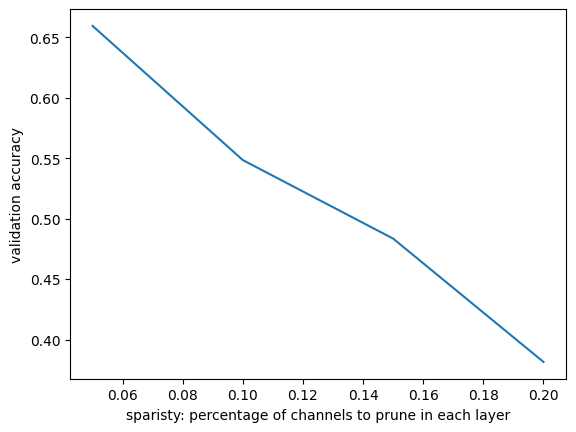

In [ ]:
def c(numbers):
    if len(numbers) == 0:
        return 0  # Handle the case where the list is empty to avoid division by zero.

    # Calculate the mean.
    mean = sum(numbers) / len(numbers)
    return mean


plt.plot([0.05,0.1,0.15,0.2],[c(a_list[:4]),c(a_list[4:8]),c(a_list[8:12]),c(a_list[12:16])])
plt.xlabel('sparisty: percentage of channels to prune in each layer')
plt.ylabel('validation accuracy')

# Kernal wise adaptive pruning rate

In [ ]:
from tensorflow.keras.models import clone_model
def prune_model_channels(model, prune_rate):
    pruned_model = clone_model(model)
    pruned_model.set_weights(model.get_weights())

    # Iterate through convolutional layers to perform channel pruning
    for i, layer in enumerate(pruned_model.layers) :
        if isinstance(layer, tf.keras.layers.Conv2D):
            weights = layer.get_weights()[0]

            for j in range(weights.shape[-2]):
              for k in range(weights.shape[-1]):
                  current_filter = weights[:, :, j, k]
                  threshold = np.percentile(np.abs(current_filter), (100 - 95)*i)
                # Set weights below the threshold to zero
                  weights[:, :, j, k] *= (np.abs(weights[:, :, j, k]) >= threshold).astype(float)

            layer.set_weights([weights, layer.get_weights()[1]])

        elif isinstance(layer, tf.keras.layers.Dense) and i!=len(pruned_model.layers)-1:
            weights = layer.get_weights()
            weight_matrix, bias_vector = weights[0], weights[1]

            threshold = np.percentile(np.abs(weight_matrix), prune_rate * 100)

            # Prune weights below the threshold by setting them to 0
            pruned_weight_matrix = np.where(np.abs(weight_matrix) < threshold, 0, weight_matrix)

            print(np.count_nonzero(pruned_weight_matrix == 0))


            # Set the pruned weights and biases back to the layer
            layer.set_weights([pruned_weight_matrix, bias_vector])


    pruned_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00015, weight_decay=1e-6),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


    val_loss, val_accuracy = pruned_model.evaluate(val_images, val_labels, batch_size=128)
    print(f"Validation Accuracy: {val_accuracy}")
    total_weights = 0
    zero_weights=0
    for layer in pruned_model.layers:
      if isinstance(layer, (tf.keras.layers.Dense,tf.keras.layers.Conv2D)):
        weights = layer.get_weights()[0]
        total_weights += np.size(weights)
        zero_weights += np.count_nonzero(weights == 0)
        print(total_weights, zero_weights)

    sparsity = zero_weights / total_weights
    print(f"zero_weights:{zero_weights}")
    print(f"total_weights:{total_weights}")
    print(f"Sparsity: {sparsity}")


    # Calculate the model score
    if val_accuracy > 0.6 and sparsity > 0:
        score = (val_accuracy + sparsity) / 2

    else:
        score = 0

    final_weights = pruned_model.get_weights()

    pruned_model.save_weights("final_weights.h5")

    print('score:',score)
    return score, final_weights

In [ ]:
score_, finalweight_ = prune_model_channels(model, prune_rate=0.85)

445644
2176
20/20 [==============================] - 1s 27ms/step - loss: 1.2166 - accuracy: 0.6626
Validation Accuracy: 0.6625742316246033
864 0
10080 1024
28512 7168
65376 23552
589664 469196
592224 471372
zero_weights:471372
total_weights:592224
Sparsity: 0.795935321770141
score: 0.7292547766973722
